In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

from scipy.stats import pearsonr

import joblib

import numpy as np
import pickle

pd.set_option('display.max_colwidth', 50)


In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [3]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
# Load data from CSV file
import pandas as pd
df = pd.read_csv('Final_Dataset_preprocessed_english.csv')#.sample(10000).reset_index(drop='index')
df.head()

,text,label,text_preprocessed,count_sentenc_text,count_words_text,num_nouns_text,num_verbs_text,num_adj_text,num_adv_text,sentiment_avg_text,features
0,donald trump just couldn t wish all americans ...,0,donald trump wish american happi new year leav...,1,287,244,9,23,11,0.9423,donald trump wish american happi new year leav...
1,house intelligence committee chairman devin nu...,0,hous intellig committe chairman devin nune go ...,1,179,148,6,23,2,0.7943,hous intellig committe chairman devin nune go ...
2,on friday it was revealed that former milwauke...,0,friday reveal former milwauke sheriff david cl...,1,339,308,9,13,9,-0.9946,friday reveal former milwauke sheriff david cl...
3,on christmas day donald trump announced that h...,0,christma day donald trump announc would back w...,1,265,227,14,14,10,0.5859,christma day donald trump announc would back w...
4,pope francis used his annual christmas day mes...,0,pope franci use annual christma day messag reb...,1,211,181,16,9,5,-0.2960,pope franci use annual christma day messag reb...


Concatenate and scale x_train with TF-IDF

In [5]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# split data into train and test sets
# x_text = df['text_preprocessed'].values
# y = df['label'].values
# x_word_count = df['count_words_text'].values.reshape(-1, 1)
# x_sent_count = df['count_sentenc_text'].values.reshape(-1, 1)
# x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
# x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
# x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
# x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
# x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1,1)

# vectorizer = TfidfVectorizer(max_features= 1000)
# x_text = vectorizer.fit_transform(x_text)

# x_train = np.concatenate([x_text.toarray(), x_word_count, x_sent_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)
# y_train = y

# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

In [6]:
# Create TF-IDF Vectors
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features = 1000)  # Set max_features as needed
X_tfidf = tfidf.fit_transform(df['features'])  # Assuming 'features' is the column containing text data

# Convert the sparse matrices to NumPy arrays
X_tfidf_array = X_tfidf.toarray()

# Define the target variable
y = df['label']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_tfidf_array, y, test_size=0.2, random_state=42)

# Define input shape with only one dimension
input_shape = (x_train.shape[1], 1)

# Reshape the input data to add the sequence length dimension so that we can fit and evaluate the CNN model
x_train_reshaped = np.expand_dims(x_train, axis=2)
x_test_reshaped = np.expand_dims(x_test, axis=2)

DNN

Epoch 1/50
1411/1411 [==============================] - 9s 5ms/step - loss: 0.7527 - accuracy: 0.5996 - val_loss: 0.6690 - val_accuracy: 0.6366
Epoch 2/50
1411/1411 [==============================] - 7s 5ms/step - loss: 0.6674 - accuracy: 0.6411 - val_loss: 0.6523 - val_accuracy: 0.6484
Epoch 3/50
1411/1411 [==============================] - 7s 5ms/step - loss: 0.6528 - accuracy: 0.6540 - val_loss: 0.6331 - val_accuracy: 0.6687
Epoch 4/50
1411/1411 [==============================] - 7s 5ms/step - loss: 0.6438 - accuracy: 0.6561 - val_loss: 0.6281 - val_accuracy: 0.6656
Epoch 5/50
1411/1411 [==============================] - 7s 5ms/step - loss: 0.6384 - accuracy: 0.6604 - val_loss: 0.6164 - val_accuracy: 0.6734
Epoch 6/50
1411/1411 [==============================] - 7s 5ms/step - loss: 0.6352 - accuracy: 0.6622 - val_loss: 0.6144 - val_accuracy: 0.6812
Epoch 7/50
1411/1411 [==============================] - 8s 6ms/step - loss: 0.6331 - accuracy: 0.6616 - val_loss: 0.6127 - val_accuracy:

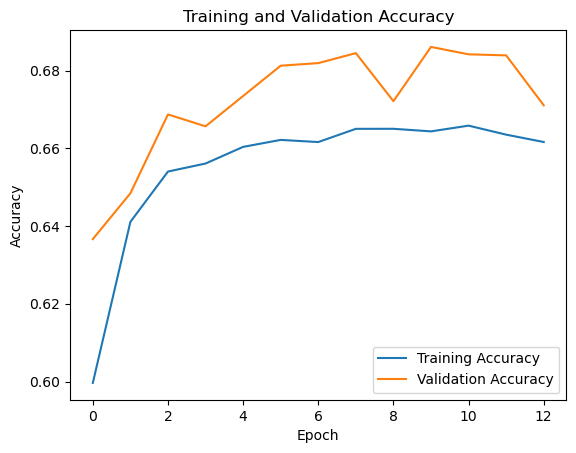

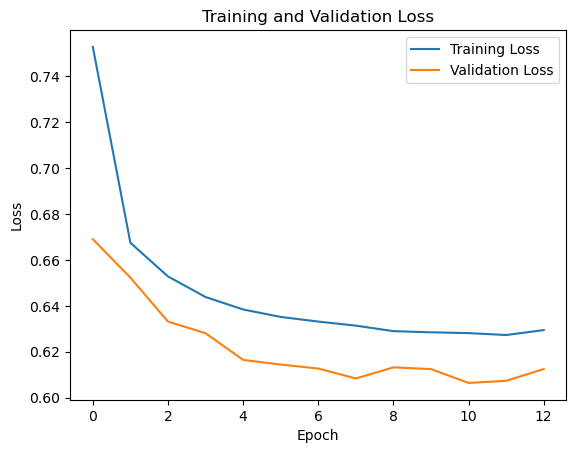

In [7]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# evaluate the model
test_loss, test_acc = model.evaluate(x=x_test, y=y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

# train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
# plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.legend(loc='best')
# plt.show()

In [9]:
# Assuming your model is named 'model' and you have 'X_test' for test data
y_pred_test = model.predict(x_test)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70     14629
           1       0.67      0.67      0.67     13590

    accuracy                           0.68     28219
   macro avg       0.68      0.68      0.68     28219
weighted avg       0.68      0.68      0.68     28219



CNN

Epoch 1/50
1411/1411 [==============================] - 41s 24ms/step - loss: 0.6924 - accuracy: 0.5141 - val_loss: 0.6913 - val_accuracy: 0.5180
Epoch 2/50
1411/1411 [==============================] - 33s 23ms/step - loss: 0.6919 - accuracy: 0.5153 - val_loss: 0.6911 - val_accuracy: 0.5188
Epoch 3/50
1411/1411 [==============================] - 33s 23ms/step - loss: 0.6916 - accuracy: 0.5160 - val_loss: 0.6910 - val_accuracy: 0.5192
Epoch 4/50
1411/1411 [==============================] - 33s 23ms/step - loss: 0.6911 - accuracy: 0.5188 - val_loss: 0.6913 - val_accuracy: 0.5089
Epoch 5/50
1411/1411 [==============================] - 33s 23ms/step - loss: 0.6910 - accuracy: 0.5162 - val_loss: 0.6909 - val_accuracy: 0.5187
Epoch 6/50
441/441 [==============================] - 4s 9ms/step - loss: 0.6913 - accuracy: 0.5183
Test loss: 0.691, Test accuracy: 0.518


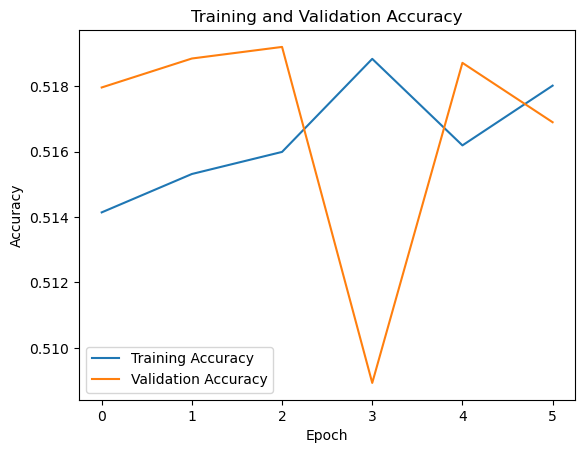

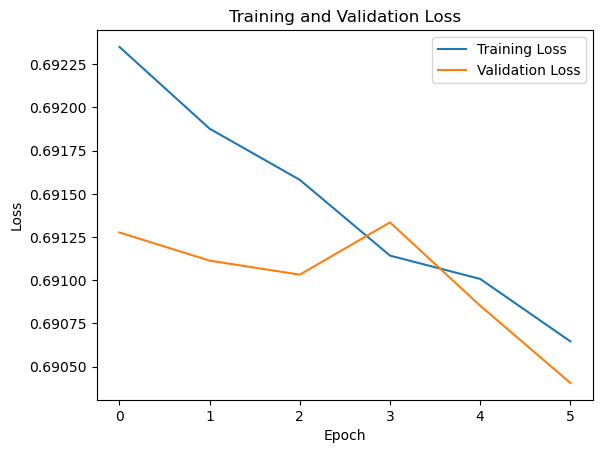

In [10]:
# reshape data for CNN input
# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

In [12]:
# Reshape the test data to add the sequence length dimension
X_test_reshaped_pred = np.expand_dims(x_test, axis=2)

# Make predictions on the reshaped test data
y_pred_test = model.predict(X_test_reshaped_pred)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.52      0.95      0.67     14629
           1       0.50      0.05      0.10     13590

    accuracy                           0.52     28219
   macro avg       0.51      0.50      0.38     28219
weighted avg       0.51      0.52      0.40     28219



RNN (takes too long, not viable)

In [25]:
# # reshape the input data for RNN
# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# define the model
model = Sequential()
model.add(Embedding(2000, 128, input_length=x_train_reshaped.shape[1]))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model and track the history
history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_test_reshaped, y_test),
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

Epoch 1/10
 135/1764 [=>............................] - ETA: 38:00 - loss: 0.6942 - accuracy: 0.5059

KeyboardInterrupt: 

LSTM

Epoch 1/50
1411/1411 [==============================] - 54s 35ms/step - loss: 0.6928 - accuracy: 0.5158 - val_loss: 0.6923 - val_accuracy: 0.5188
Epoch 2/50
1411/1411 [==============================] - 51s 36ms/step - loss: 0.6923 - accuracy: 0.5154 - val_loss: 0.6916 - val_accuracy: 0.5187
Epoch 3/50
1411/1411 [==============================] - 51s 36ms/step - loss: 0.6914 - accuracy: 0.5220 - val_loss: 0.6902 - val_accuracy: 0.5251
Epoch 4/50
1411/1411 [==============================] - 52s 37ms/step - loss: 0.6913 - accuracy: 0.5251 - val_loss: 0.6905 - val_accuracy: 0.5227
Epoch 5/50
1411/1411 [==============================] - 52s 37ms/step - loss: 0.6909 - accuracy: 0.5244 - val_loss: 0.6901 - val_accuracy: 0.5133
Epoch 6/50
441/441 [==============================] - 6s 14ms/step - loss: 0.6905 - accuracy: 0.5266
Test loss: 0.691, Test accuracy: 0.527


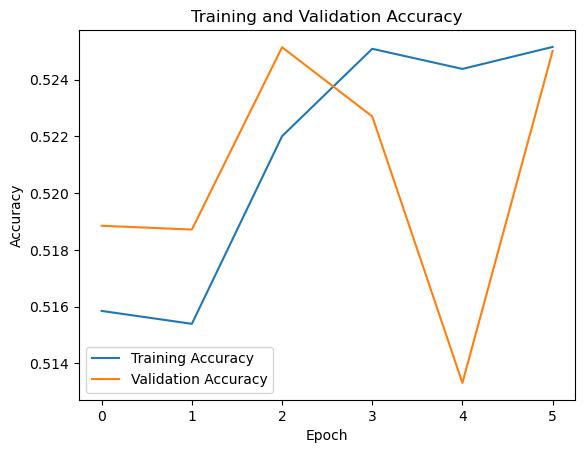

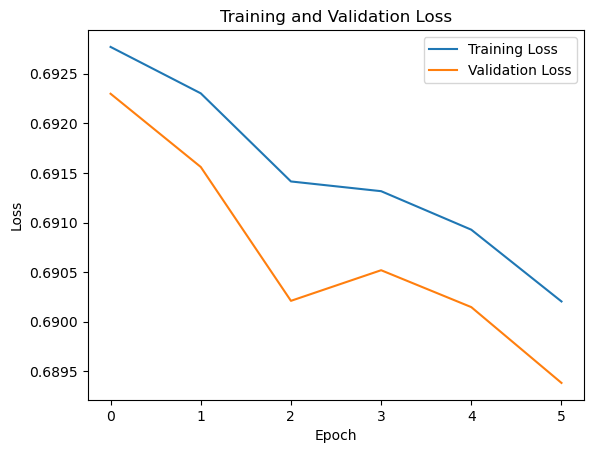

In [7]:
# reshape the input data for LSTM
# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_reshaped.shape[1],  1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model and track the history
history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_test_reshaped, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])
#callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

In [8]:
# Reshape the test data to add the sequence length dimension
X_test_reshaped_pred = np.expand_dims(x_test, axis=2)

# Make predictions on the reshaped test data
y_pred_test = model.predict(X_test_reshaped_pred)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.53      0.89      0.66     14629
           1       0.53      0.13      0.21     13590

    accuracy                           0.53     28219
   macro avg       0.53      0.51      0.44     28219
weighted avg       0.53      0.53      0.45     28219



Bi-LSTM

Epoch 1/20
1411/1411 [==============================] - 132s 89ms/step - loss: 0.6939 - accuracy: 0.5118 - val_loss: 0.6921 - val_accuracy: 0.5188
Epoch 2/20
1411/1411 [==============================] - 125s 88ms/step - loss: 0.6921 - accuracy: 0.5172 - val_loss: 0.6908 - val_accuracy: 0.5210
Epoch 3/20
1411/1411 [==============================] - 125s 88ms/step - loss: 0.6914 - accuracy: 0.5221 - val_loss: 0.6901 - val_accuracy: 0.5280
Epoch 4/20
1411/1411 [==============================] - 123s 88ms/step - loss: 0.6905 - accuracy: 0.5249 - val_loss: 0.6907 - val_accuracy: 0.5222
Epoch 5/20
1411/1411 [==============================] - 124s 88ms/step - loss: 0.6920 - accuracy: 0.5215 - val_loss: 0.6897 - val_accuracy: 0.5235
Epoch 6/20
441/441 [==============================] - 16s 35ms/step - loss: 0.6905 - accuracy: 0.5272
Test loss: 0.691, Test accuracy: 0.527


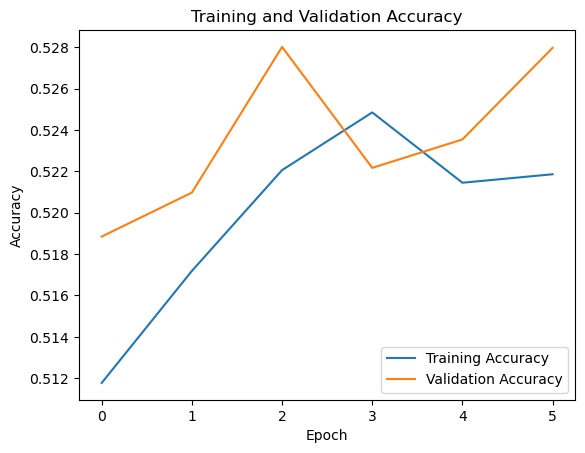

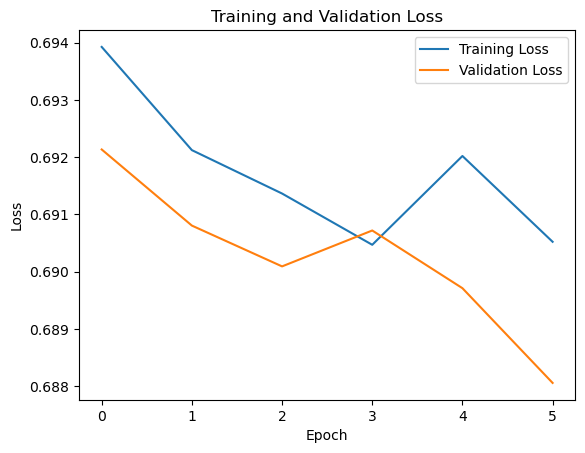

In [9]:
# class DataGenerator(Sequence):
#     def __init__(self, x_set, y_set, batch_size):
#         self.x, self.y = x_set, y_set
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y

# # reshape the input data for Bi-LSTM
# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)


# train_gen = DataGenerator(x_train_reshaped, y_train, 64)
# test_gen = DataGenerator(x_test_reshaped, y_test, 64)

# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# define the model
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(x_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model and track the history
history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_test_reshaped, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])
#callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

In [10]:
# Reshape the test data to add the sequence length dimension
X_test_reshaped_pred = np.expand_dims(x_test, axis=2)

# Make predictions on the reshaped test data
y_pred_test = model.predict(X_test_reshaped_pred)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.53      0.78      0.63     14629
           1       0.52      0.25      0.34     13590

    accuracy                           0.53     28219
   macro avg       0.52      0.52      0.48     28219
weighted avg       0.52      0.53      0.49     28219



BERT with more features

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# split data into train and test sets
x_text = df['text_preprocessed'].values
y = df['label'].values
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1,1)

vectorizer = TfidfVectorizer(max_features=1000)
x_text = vectorizer.fit_transform(x_text)

x_train = np.concatenate([x_text.toarray(), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)
y_train = y

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [6]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Truncate or pad the sequences to length 128
x_train_ids = pad_sequences(x_train, maxlen=128, dtype="long", value=0, truncating="post", padding="post")
x_test_ids = pad_sequences(x_test, maxlen=128, dtype="long", value=0, truncating="post", padding="post")

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
1764/1764 [==============================] - 1247s 703ms/step - loss: 1.2615 - accuracy: 0.5444 - val_loss: 0.8115 - val_accuracy: 0.5769
Epoch 2/5
1764/1764 [==============================] - 1237s 701ms/step - loss: 1.1804 - accuracy: 0.5699 - val_loss: 0.8429 - val_accuracy: 0.5883
Epoch 3/5
1764/1764 [==============================] - 1248s 708ms/step - loss: 1.2081 - accuracy: 0.5853 - val_loss: 2.3804 - val_accuracy: 0.5021
Epoch 4/5
1764/1764 [==============================] - 1232s 698ms/step - loss: 1.2326 - accuracy: 0.5846 - val_loss: 1.0889 - val_accuracy: 0.5716
Epoch 5/5
441/441 [==============================] - 222s 504ms/step - loss: 0.8429 - accuracy: 0.5883
Test loss: 0.8429
Test accuracy: 0.5883


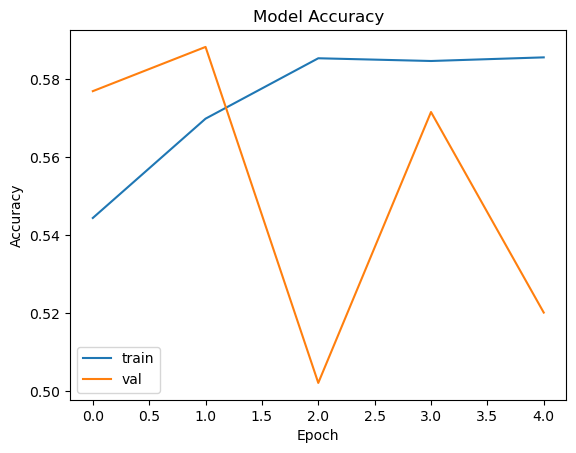

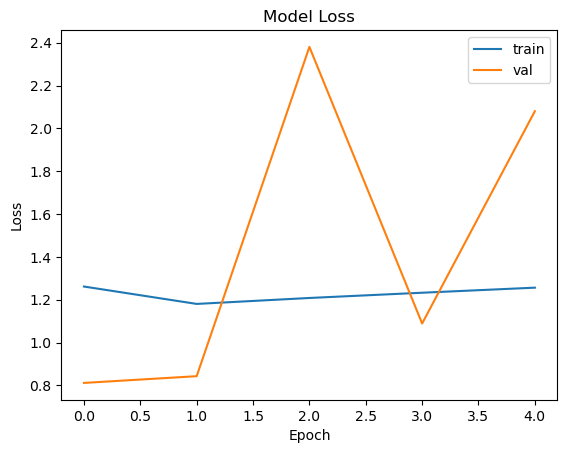

In [7]:
# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([x_train_ids, x_train_scaled],
                    y_train,
                    validation_data=([x_test_ids, x_test_scaled],y_test),
                    epochs=5,
                    batch_size=64,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
                    )

# Evaluate the model
loss, accuracy = model.evaluate([x_test_ids, x_test_scaled], y_test, batch_size = 64)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Make predictions using the model
y_pred_probs = model.predict([x_test_ids, x_test_scaled])

# Define a threshold for converting probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

print(classification_rep)

              precision    recall  f1-score   support

           0       0.81      0.27      0.41     14629
           1       0.54      0.93      0.68     13590

    accuracy                           0.59     28219
   macro avg       0.67      0.60      0.55     28219
weighted avg       0.68      0.59      0.54     28219



RoBERTa with features

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# split data into train and test sets
x_text = df['text_preprocessed'].values
y = df['label'].values
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1,1)

vectorizer = TfidfVectorizer(max_features=1000)
x_text = vectorizer.fit_transform(x_text)

x_train = np.concatenate([x_text.toarray(), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)
y_train = y

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [6]:
# Load the pre-trained RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Freeze the pre-trained layers
for layer in roberta_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Truncate or pad the sequences to length 128
x_train_ids = pad_sequences(x_train, maxlen=128, dtype="long", value=0, truncating="post", padding="post")
x_test_ids = pad_sequences(x_test, maxlen=128, dtype="long", value=0, truncating="post", padding="post")

# Pass the input through the pre-trained BERT model
sequence_output = roberta_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20
5644/5644 [==============================] - 1219s 215ms/step - loss: 0.9040 - accuracy: 0.5717 - val_loss: 0.6546 - val_accuracy: 0.6425
Epoch 2/20
5644/5644 [==============================] - 1204s 213ms/step - loss: 0.9188 - accuracy: 0.5937 - val_loss: 0.6627 - val_accuracy: 0.6389
Epoch 3/20
5644/5644 [==============================] - 1212s 215ms/step - loss: 0.9466 - accuracy: 0.5965 - val_loss: 0.6668 - val_accuracy: 0.6458
Epoch 4/20
5644/5644 [==============================] - 1212s 215ms/step - loss: 0.9470 - accuracy: 0.5966 - val_loss: 0.6724 - val_accuracy: 0.6447
Epoch 5/20
5644/5644 [==============================] - 1215s 215ms/step - loss: 0.9723 - accuracy: 0.5929 - val_loss: 0.7277 - val_accuracy: 0.6402
Epoch 6/20
882/882 [==============================] - 241s 274ms/step - loss: 0.6667 - accuracy: 0.6443
Test loss: 0.6667
Test accuracy: 0.6443


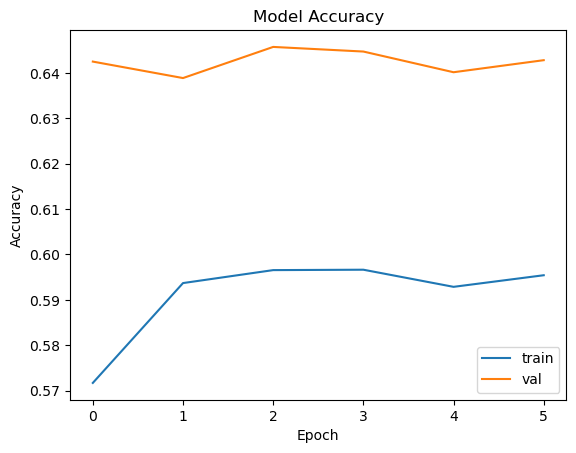

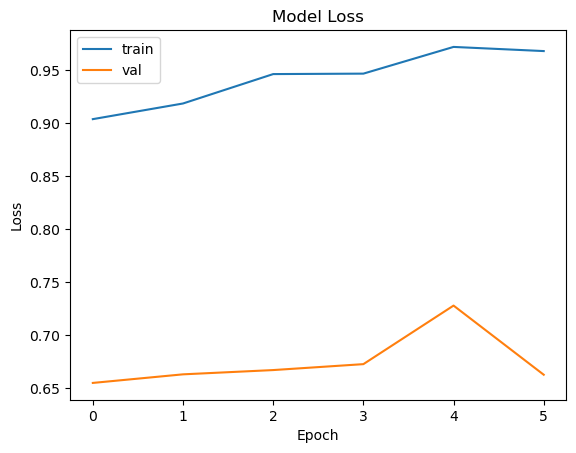

In [7]:
# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([x_train_ids, x_train_scaled],
                    y_train,
                    validation_data=([x_test_ids, x_test_scaled], y_test),
                    epochs=20,
                    batch_size=16,
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# Evaluate the model
loss, accuracy = model.evaluate([x_test_ids, x_test_scaled], y_test)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Make predictions using the model
y_pred_probs = model.predict([x_test_ids, x_test_scaled])

# Define a threshold for converting probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

print(classification_rep)

              precision    recall  f1-score   support

           0       0.65      0.70      0.67     14629
           1       0.64      0.59      0.61     13590

    accuracy                           0.64     28219
   macro avg       0.64      0.64      0.64     28219
weighted avg       0.64      0.64      0.64     28219



XLNET with features

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# split data into train and test sets
x_text = df['text_preprocessed'].values
y = df['label'].values
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_sent_count = df['count_sentenc_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)

vectorizer = TfidfVectorizer(max_features=1000)
x_text = vectorizer.fit_transform(x_text)

x_train = np.concatenate([x_text.toarray(), x_word_count, x_sent_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count], axis=1)
y_train = y

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [6]:
# Load the pre-trained XLNet model
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

# Freeze the pre-trained layers
for layer in xlnet_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Truncate or pad the sequences to length 128
x_train_ids = pad_sequences(x_train, maxlen=128, dtype="long", value=0, truncating="post", padding="post")
x_test_ids = pad_sequences(x_test, maxlen=128, dtype="long", value=0, truncating="post", padding="post")

# Pass the input through the pre-trained BERT model
sequence_output = xlnet_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [7]:
# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([sequence_output_flattened, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([x_train_ids, x_train_scaled],
                    y_train,
                    validation_data=([x_test_ids, x_test_scaled],
                    y_test),
                    epochs=30,
                    batch_size=16,
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/30
5644/5644 [==============================] - 1447s 255ms/step - loss: 6.0891 - accuracy: 0.5207 - val_loss: 15.0104 - val_accuracy: 0.4813
Epoch 2/30
5644/5644 [==============================] - 1439s 255ms/step - loss: 5.6183 - accuracy: 0.5469 - val_loss: 4.8647 - val_accuracy: 0.5322
Epoch 3/30
5644/5644 [==============================] - 1435s 254ms/step - loss: 5.9182 - accuracy: 0.5571 - val_loss: 3.0383 - val_accuracy: 0.5754
Epoch 4/30
5644/5644 [==============================] - 1435s 254ms/step - loss: 6.1292 - accuracy: 0.5652 - val_loss: 4.6507 - val_accuracy: 0.5490
Epoch 5/30
5644/5644 [==============================] - 1427s 253ms/step - loss: 6.3289 - accuracy: 0.5669 - val_loss: 4.2501 - val_accuracy: 0.5641
Epoch 6/30
5644/5644 [==============================] - 1429s 253ms/step - loss: 6.2308 - accuracy: 0.5711 - val_loss: 2.1310 - val_accuracy: 0.6375
Epoch 7/30
5644/5644 [==============================] - 1415s 251ms/step - loss: 6.6142 - accuracy: 0.573

3528/3528 [==============================] - 353s 100ms/step - loss: 2.1575 - accuracy: 0.6383
Test loss: 2.1575
Test accuracy: 0.6383


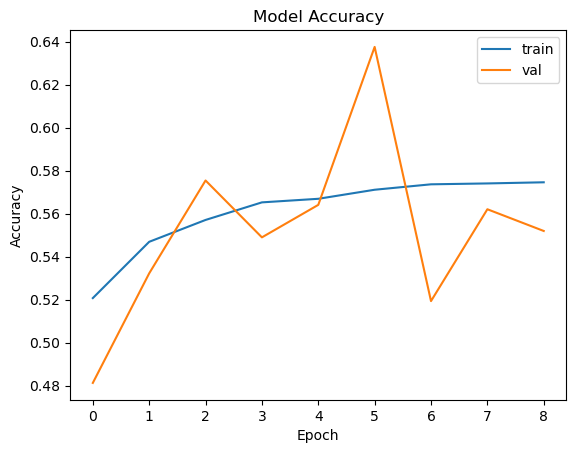

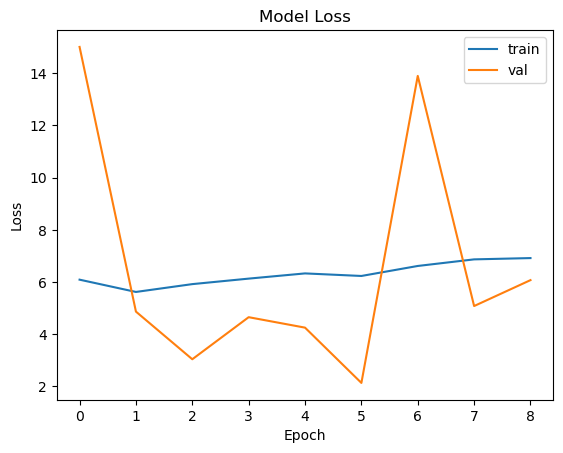

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate([x_test_ids, x_test_scaled], y_test, batch_size=8)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Make predictions using the model
y_pred_probs = model.predict([x_test_ids, x_test_scaled])

# Define a threshold for converting probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

print(classification_rep)

              precision    recall  f1-score   support

           0       0.61      0.85      0.71     14629
           1       0.72      0.41      0.52     13590

    accuracy                           0.64     28219
   macro avg       0.66      0.63      0.62     28219
weighted avg       0.66      0.64      0.62     28219

